### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings


warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results)
try:
    import xgboost as xgb
except:
    print("❌ XGBoost não encontrado. Instale com: pip install xgboost")

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgb.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2
XGBoost: 3.1.2


### 1.2 Definir Nome do Modelo

In [2]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "XGBoost"
print(f"Modelo: {MODEL_NAME}")

Modelo: XGBoost


### 1.3 Carregar Datasets

In [3]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar e preparar datasets usando função do módulo
(X_train, X_test, y_train, y_test, 
 X_train_scaled, X_test_scaled, 
 train_data, test_data, scaler) = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}


In [ ]:
train_data.head()

## 2. Sampling para Busca de Hiperparâmetros

In [4]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.05, 
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 3,640 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 2709, 1.0: 931}
Original: {0.0: 54175, 1.0: 18620}


## 3 Definir Folds

In [5]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. XGBoost - Busca de Hiperparâmetros

In [6]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME}  ===")

# Definição do Espaço de Hiperparâmetros para XGBoost (apenas parâmetros variáveis)
param_distributions = {
    'n_estimators': randint(140, 381),  # Número de árvores
    'max_depth': randint(3, 11),  # Profundidade máxima das árvores
    'learning_rate': uniform(0.5, 1.5),  # Taxa de aprendizado
    'subsample': uniform(0.6, 0.3),  # Fração das amostras para cada árvore
    'colsample_bytree': uniform(0.2, 0.5),  # Fração das features para cada árvore
    'reg_alpha': uniform(0.5, 1.5),  # Regularização L1
    'reg_lambda': uniform(0.5, 1.5),  # Regularização L2
    'min_child_weight': randint(1, 20),  # Peso mínimo das folhas 
    'gamma': uniform(0.1, 0.4),  # Redução mínima de perda para split 
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")

model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',     # Para classificação binária
        eval_metric='logloss',           # Métrica de avaliação
        random_state=42,                 # Reprodutibilidade
        n_jobs=-1,                       # Usar todos os cores
        verbosity=0                      # Silencioso
    ),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=80,      
    scoring='f1',
    n_jobs=-1,
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - XGBoost  ===
Iniciando busca de hiperparâmetros para XGBoost...
Executando 20 buscas com 80 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.5422
Melhor configuração desta busca: {'colsample_bytree': np.float64(0.4860856621478309), 'gamma': np.float64(0.32667855441066146), 'learning_rate': np.float64(0.5378250739461665), 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 176, 'reg_alpha': np.float64(1.6456089239845815), 'reg_lambda': np.float64(1.3188255377360552), 'subsample': np.float64(0.845339753505576)}
Melhor score geral até agora: 0.5422

Busca 2/20...
Melhor score desta busca: 0.5441
Melhor configuração desta busca: {'colsample_bytree': np.float64(0.4551857465304453), 'gamma': np.float64(0.2124146508979553), 'learning_rate': np.float64(0.7625856748742161), 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 364, 'reg_alpha': np.float64(1.0101097314790075), 'reg_lambda': np.float64(1.8204680493048513), 'subsample': np.float64(0.6

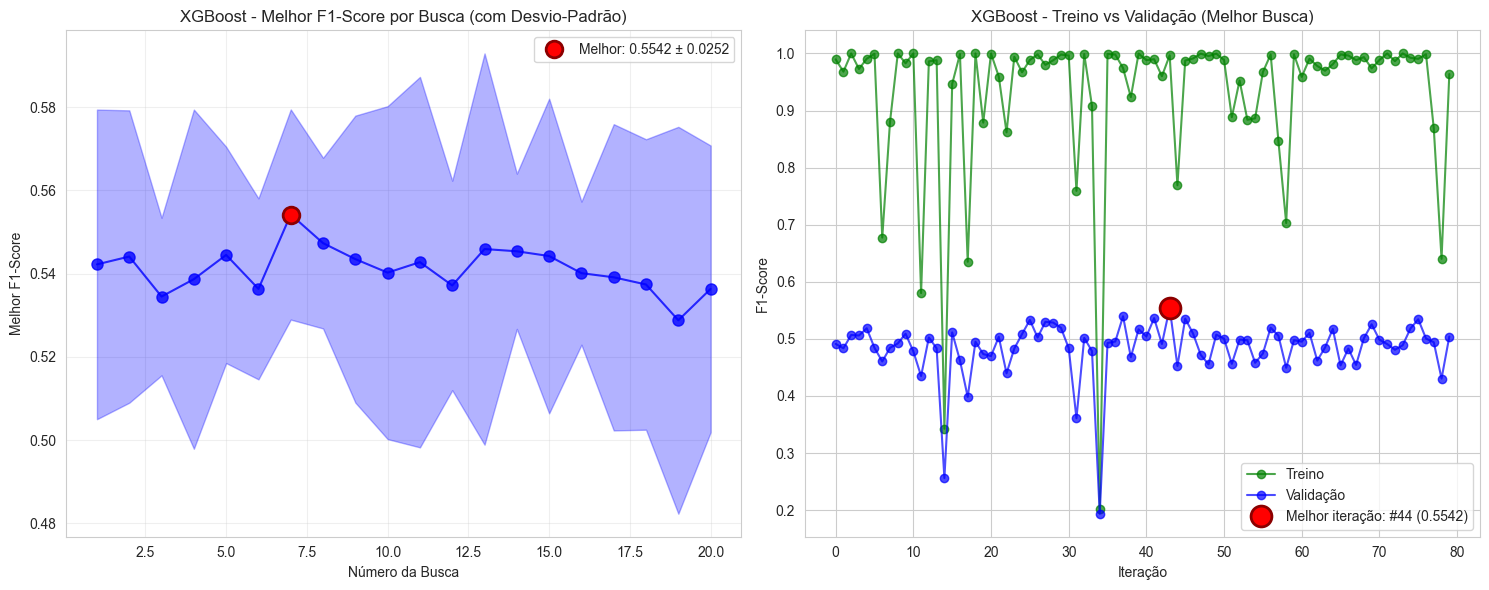

In [7]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_all_searches, model_search, MODEL_NAME)

In [8]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== TOP 20 MELHORES CONFIGURAÇÕES - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'N_Estimators': search_result['best_params']['n_estimators'],
        'Max_Depth': search_result['best_params']['max_depth'],
        'Learning_Rate': search_result['best_params']['learning_rate'],
        'Subsample': search_result['best_params']['subsample'],
        'Colsample_Bytree': search_result['best_params']['colsample_bytree'],
        'Reg_Alpha': search_result['best_params']['reg_alpha'],
        'Reg_Lambda': search_result['best_params']['reg_lambda'],
        'Min_Child_Weight': search_result['best_params']['min_child_weight'],
        'Gamma': search_result['best_params']['gamma']
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'N_Estimators', 'Max_Depth', 
                        'Learning_Rate', 'Subsample', 'Colsample_Bytree', 'Reg_Alpha', 
                        'Reg_Lambda', 'Min_Child_Weight', 'Gamma']]

# Mostrar tabela formatada
print("Top 20 Configurações (ordenadas por F1-Score Binário):")
print("-" * 170)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

=== TOP 20 MELHORES CONFIGURAÇÕES - XGBoost ===
Top 20 Configurações (ordenadas por F1-Score Binário):
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Ranking  Busca  F1_Score  N_Estimators  Max_Depth  Learning_Rate  Subsample  Colsample_Bytree  Reg_Alpha  Reg_Lambda  Min_Child_Weight  Gamma
       1      7    0.5542           190          7         0.5019     0.8239            0.6301     0.6653      0.9341                 9 0.3440
       2      8    0.5473           234          8         0.6610     0.8097            0.3780     1.3145      1.0558                 8 0.1877
       3     13    0.5459           311         10         0.6673     0.8640            0.4932     1.0150      1.7249                 3 0.2332
       4     14    0.5454           215          4         0.5324     0.8578            0.2523     1.4241      1.3805                 4 0.4653
       5   

## 5. Salvar Resultados de Busca

In [9]:
# Salvar Resultados da Busca de Hiperparâmetros usando função do módulo
search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=model_search,
    model_all_searches=model_all_searches,
    n_searches=20,
    n_iter_per_search=80,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['n_estimators', 'max_depth', 'learning_rate', 'subsample', 
                       'colsample_bytree', 'reg_alpha', 'reg_lambda', 'min_child_weight', 'gamma'],
    searches_folder='searches'
)

=== SALVANDO RESULTADOS DA BUSCA - XGBOOST ===
  ✅ Todos os Resultados salvos: searches\xgboost_all_searches.csv
  Total de configurações testadas: 1,600
  ✅ Resumo salvo: searches\xgboost_search_summary.json

--- ESTATÍSTICAS DA BUSCA XGBOOST ---
Melhor F1-Score: 0.5542
Desvio padrão do melhor: 0.0252
F1-Score médio geral: 0.4816
F1-Score mínimo: 0.0820
F1-Score máximo: 0.5542


## 5.2 Carregar Resultado de busca

In [5]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - XGBOOST ===
✅ Resultados detalhados carregados: 800 configurações
✅ Resumo carregado: F1-Score = 0.1255
⚠️  Arquivo não encontrado: searches\xgboost_full_search.pkl


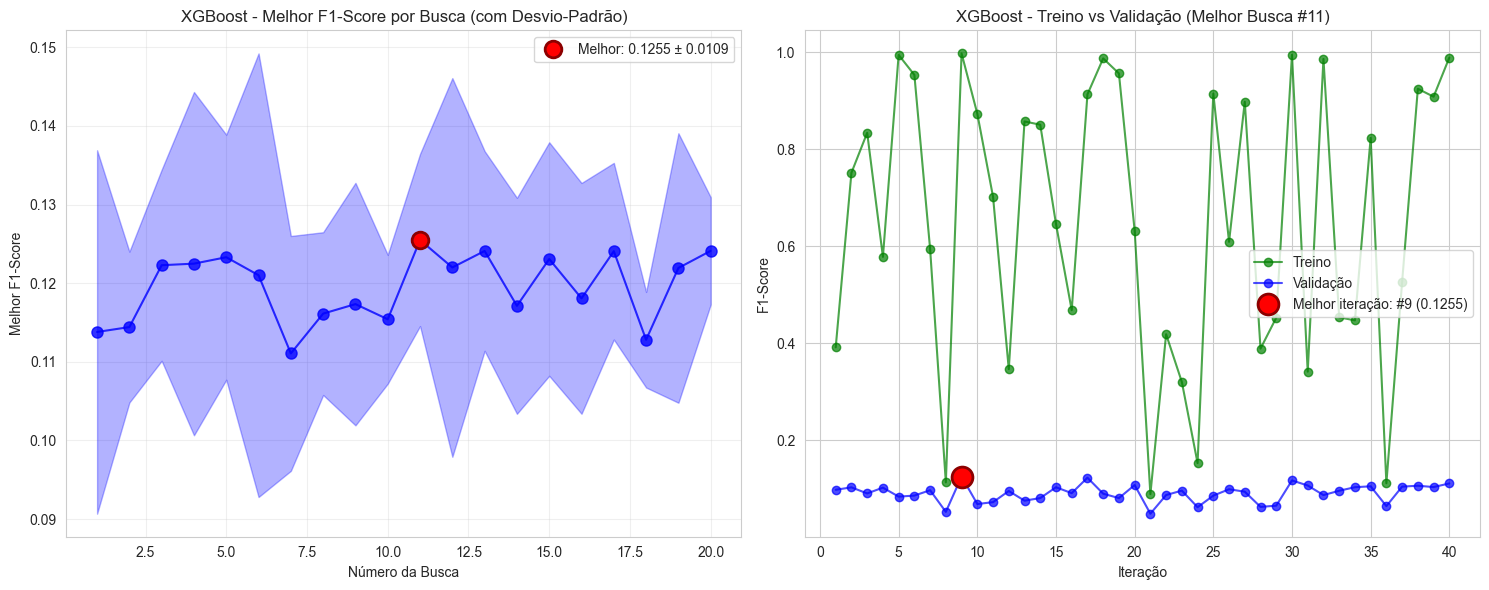

In [6]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [10]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Usando parâmetros da busca atual: {'colsample_bytree': np.float64(0.630136081840562), 'gamma': np.float64(0.3440211235296379), 'learning_rate': np.float64(0.5019257201500111), 'max_depth': 7, 'min_child_weight': 9, 'n_estimators': 190, 'reg_alpha': np.float64(0.6653372537974918), 'reg_lambda': np.float64(0.9341479007588223), 'subsample': np.float64(0.8239405984249891)}
✅ Melhor F1-Score da busca atual: 0.5542


## 6. Treinar Modelo Final e Salvar

In [11]:
# Treinamento Final com melhores hiperparâmetros
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")


Modelo final XGBoost treinado: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.630136081840562), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.3440211235296379), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.5019257201500111), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=190, n_jobs=None,
              num_parallel_tree=None, ...)
Modelo salvo: models/xgboost_trained.joblib


## 7. Avaliação Final e Salvamento dos Resultados

In [ ]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [12]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - XGBoost ===

Avaliando performance do modelo...


In [13]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder='results'
)

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

✅ Resultados XGBoost salvos em: results\xgboost_results.json

--- RESUMO XGBoost ---
F1-Score CV: 0.5542
F1-Score Teste: 0.4709
Acurácia Teste: 0.7800
Precisão Teste: 0.7177
Recall Teste: 0.3504
G-Mean Teste: 0.5759
AUC-ROC Teste: 0.7967
